# 이해하기 : GAN

<img src='./figs/13_01.png'>

- 가짜 이미지를 만들어내도록 학습하는 생성자
    - 특징 공간의 점을 입력 받아 이미지 생성
    - 특징 공간 : 이미지의 특징들로 표현되는 공간
- 가짜와 진짜 이미지를 구별하는 감별자
    - 감별자는 진짜 이미지인지, 생성된 것인지를 이진 분류
- 생성자와 감별자를 경쟁시켜 학습하면, 생성자는 점점 진짜 같은 이미지를 만들어 낼 것
- 단점
    - 학습이 올바로 이루어지기 어렵고
    - 많은 데이터 필요
    - 사용하는 특징의 개수에 매우 민감

# 이해하기 : 특징 공간

<img src='./figs/13_02.png'>

- 나선형의 데이터 분포의 특징을 추출해 2차원으로 표현한 것
- A와 B의 평균값을 구할 때 3차원과 2차원의 특징 공간상의 평균값에 큰 차이가 발생

<img src='./figs/13_03.png'>

- 특징 1이 가로를, 특징 2가 세로의 특징을 의미한다면
- 두개를 합치면 대각선이 될 것 (그림에서 A와 B의 위치가 달라져야 할 것)
- 특징 공간이란, 사람이 인식하는 사물의 특징을 표현하는 공간

<img src='./figs/13_04.png'>

- 사람의 손글씨 이미지를 2차원 특징공간에 표현한 것
- 인공지능이 학습한 특징을 표현한 것
- 사람의 얼굴을 합성하거나, 안경을 쓴 얼굴 사진에서 안경만 제거 하는 등의 기능을 만들 수도

# 데이터 살펴보기

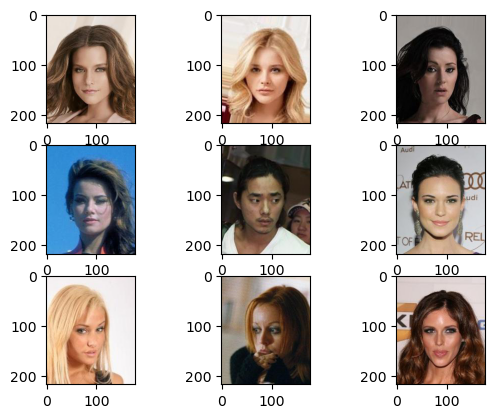

In [1]:
import glob
import matplotlib.pyplot as plt
import os

from PIL import Image
import random

# data_path = '/home/restful3/datasets/kaggle/GAN/celeba/'
# data_path = '/Volumes/data/dataset/img_align_celeba'
data_path = '/home/restful3/datasets_local/GAN/img_align_celeba/'
imgs = glob.glob(os.path.join(data_path, "*"))

if len(imgs):
    idxs = random.sample(range(len(imgs)), 9)

    for i, n in enumerate(idxs):
        plt.subplot(3, 3, 1+i)
        img = Image.open(imgs[n])
        plt.imshow(img)

    plt.show()

- 가로 세로 비율이 동일하지 않아 변환 필요

# 학습용 데이터셋 만들기

<img src='./figs/13_05.png'>

- 클래스 별로 폴더를 만들고 이미지 파일을 모아 둔다
- ImageFolder()에 최상위 정보를 입력해주면 자동으로 클레스별 이미지를 읽어 파이토치 Dataset 객체로 반환
- 본 과제에서는 클래스(분류)가 없음, 클래스명을 데이터 폴더명으로 지정
- 폴더 구성
    - GAN
        - img_align_celeba

In [2]:
import torch
import torchvision.transforms as tf

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

transforms = tf.Compose([
    tf.Resize(64), # 이미지를 64x64 로 리사이즈
    tf.CenterCrop(64), # 중간을 잘라내기
    tf.ToTensor(), 
    tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(
#     root = '/home/restful3/datasets/kaggle/GAN',
#     root = '/Volumes/data/dataset',
    root = '/home/restful3/datasets_local/GAN',
    transform=transforms
)

loader = DataLoader(dataset, batch_size=128, shuffle=True)

/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


<img src='./figs/13_06.png'>

- 입력된 이미지가 64인데, tf.CenterCrop(64) 하는게 의미가 있나?
    - tf.CenterCrop(64)는 이미지의 중앙 부분을 잘라내는 변환(transform)을 의미합니다. 이 변환은 이미지의 가로와 세로 크기를 입력된 값인 64로 설정하고, 중앙 부분을 유지하고 나머지 부분을 잘라냅니다.
    - 예를 들어, 주어진 이미지가 가로와 세로 크기가 각각 200인 경우 tf.CenterCrop(64)를 적용하면 가로와 세로 크기가 64인 이미지로 변환됩니다. 이때 변환은 원본 이미지의 중앙 부분을 기준으로 잘라냅니다. 잘라낸 이미지는 중앙에 위치하며, 가로와 세로 크기는 모두 64로 조정됩니다.

# GAN 생성자 정의하기

<img src='./figs/13_07.png'>

- 100차원의 특징을 받는다.
- 특징이 너무 작으면 학습은 쉬워 지지만 성능이 낮고, 너무 크면 성능은 높아 지지만 학습이 어려워 진다. 

In [3]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False), # 편향을 사용하지 않음
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.Tanh()            
        )
        
    def forward(self, x):
        x = self.gen(x)       
        
        return x

- nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False)
    - 코드는 PyTorch의 nn.ConvTranspose2d를 사용하여 생성자의 일부분인 컨볼루션 전치(transposed convolution) 레이어를 정의하는 부분입니다. 컨볼루션 전치는 이미지의 크기를 확대하는 데 사용되며, 생성자에서 잡음 벡터를 이용해 점차적으로 이미지를 생성하는 데 도움을 줍니다.
    - 해당 코드에서 nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False)은 다음과 같은 역할과 매개변수를 갖습니다:
        - 100은 입력 채널 수입니다. 이는 컨볼루션 전치 레이어에 입력되는 특징 맵의 채널 수를 의미합니다. 여기서는 잡음 벡터의 크기로 설정되었습니다.
        - 512는 출력 채널 수입니다. 이는 컨볼루션 전치 레이어에서 생성된 특징 맵의 채널 수를 의미합니다.
        - kernel_size=4는 컨볼루션 전치 레이어의 필터 크기를 나타냅니다. 이 경우, 필터의 크기는 4x4입니다.
        - bias=False는 편향(bias)을 사용하지 않음을 의미합니다.
    - 이 컨볼루션 전치 레이어는 잡음 벡터를 입력으로 받아 크기가 4배로 확대된 특징 맵을 출력합니다. 이렇게 생성된 특징 맵은 생성자의 다음 레이어로 전달되어 이미지 생성 과정을 진행하게 됩니다. 이를 통해 생성자는 잡음 벡터로부터 점차적으로 복잡한 구조의 가짜 이미지를 생성하게 됩니다.

- 생성자의 마지막 층은 각 픽셀의 값을 결정 하는 층
    - 배치 정규화를 하지 않는다
    - Tanh() 를 활성함수로 사용, 원점 대칭, 어두운 색과 밝은 색을 대칭적으로 학습 시키려고

# GAN 감별자 정의하기

<img src='./figs/13_08.png'>

- 생성자와 유사
- 활성함수를 LeakyReLU() 사용

<img src='./figs/13_09.png'>

In [4]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # 편향을 사용하지 않음
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2), # negative_slope: Controls the angle of the negative slope. Default: 1e-2
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),   
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4), 
            nn.Sigmoid()            
        )
        
    def forward(self, x):
        x = self.disc(x)
        
        return x

- 감별자는 생성자가 만들어낸 이미지의 진위 여부 판별
- 합성곱, 배치 정규화, 활성화를 거치는 구조
- 이미지의 진위 여부 판별 - 이진 분류, 배치 정규화 하지 않음

# 가중치 초기화하기

- GAN의 학습이 잘 된다고 알려진 초기화 값
    - 합성곱층 : 평균 0, 표준편차 0.02 정규분포
    - 배치 정규화층 : 평균 1.0, 표준편차 0.02 정규분포
    - 배치 정규화층의 편향 : 0

In [5]:
def weights_init(m):
    # 층의 종류 추출
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        # 합성곱층 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02) # 정규분포를 따라 가중치 초기화, 가중치를 사용하지 않게 설정 되어 있음
    elif classname.find('BatchNorm') != -1:
        # 배치 정규화층 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0) # 편향을 0으로 초기화

# 모델 학습하기

- 감별자와 생성자를 번갈아 가면서 학습
- 감별자
    - 감별자에게 진짜 이미지를 구별 하도록, 진짜 이미지 배치와 생성자의 가짜 이미지를 한 배치 학습
- 생성자
    - 생성자가 만들어낸 이미지를 감별자가 진짜라고 판단하도록 생성자 학습

<img src='./figs/13_10.png'>

In [6]:
import tqdm

from torch.optim.adam import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = 'cpu'
device

'cuda'

In [7]:
# 생성자 정의
G = Generator().to(device)
# 생성자 초기화 
G.apply(weights_init)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [8]:
# 감별자 정의
D = Discriminator().to(device)
# 감별자 가중치 초기화
D.apply(weights_init)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (13): Sigmoid()
  )
)

In [9]:
G_optim = Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

- betas=(0.5, 0.999)는 Adam 알고리즘에서 사용되는 두 개의 감마 매개변수(betas)를 나타냅니다. 
- 첫 번째 감마 값은 이동 평균의 계수에 사용되며, 두 번째 감마 값은 제곱된 이동 평균의 계수에 사용됩니다. 
- 이러한 이동 평균은 그래디언트의 추정치를 계산하는 데 사용되며, 학습의 안정성을 향상시키는 역할을 합니다.

In [10]:
import torch, gc
import torch.autograd as autograd
autograd.set_detect_anomaly(True)

for epoch in range(50):
    iterator = tqdm.tqdm(enumerate(loader, 0), total=len(loader))
    gc.collect()
    torch.cuda.empty_cache()    

    for i, data in iterator:
        D_optim.zero_grad()
        
        # 실제 이미지에는 1, 생성된 이미지에는 0으로 정답 설정
        label = torch.ones_like(data[1], dtype=torch.float32).to(device)
        label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)
        
        # 실제 이미지를 감별자에게 입력
        real = D(data[0].to(device))
        # 실제 이미지에 대한 감별자의 오차 계산, 진짜는 1로 판정 하도록 학습 시킴
        D_loss_real = nn.BCELoss()(torch.squeeze(real), label)
        D_loss_real.backward()
        
        # 가짜 이미지 생성, 100개의 특징을 사용 
        noise = torch.randn(label.shape[0], 100, 1, 1, device=device)
        fake = G(noise)
        
        # 가짜 이미지를 감별자에 입력
        output = D(fake.detach())
        
        # 가짜 이미지에 대한 감별자의 오차 계산
        D_loss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
        D_loss_fake.backward()
        
        # 감별자의 전체 오차
        D_loss = D_loss_real + D_loss_fake
        D_optim.step()
    
        # 생성자의 학습
        G_optim.zero_grad()
        output = D(fake)
        G_loss = nn.BCELoss()(torch.squeeze(output), label)
        G_loss.backward()
        
        G_optim.step()

        iterator.set_description(f'epoch : {epoch}, iteration : {i}/{len(iterator)}, D_loss : {D_loss}, G_loss : {G_loss}')
        
        
torch.save(G.state_dict(), "./models/Generator.pth")
torch.save(D.state_dict(), "./models/Discriminator.pth")

epoch : 0, iteration : 1582/1583, D_loss : 1.3696861267089844, G_loss : 0.772222
epoch : 1, iteration : 1582/1583, D_loss : 1.4035228490829468, G_loss : 0.826866
epoch : 2, iteration : 1582/1583, D_loss : 1.3748478889465332, G_loss : 1.121987
epoch : 3, iteration : 1582/1583, D_loss : 1.2715322971343994, G_loss : 1.381788
epoch : 4, iteration : 1582/1583, D_loss : 1.2355256080627441, G_loss : 2.868810
epoch : 5, iteration : 1582/1583, D_loss : 1.3601875305175781, G_loss : 0.591003
epoch : 6, iteration : 1582/1583, D_loss : 0.8537143468856812, G_loss : 1.685886
epoch : 7, iteration : 1582/1583, D_loss : 0.7255719900131226, G_loss : 1.652749
epoch : 8, iteration : 1582/1583, D_loss : 0.7028274536132812, G_loss : 1.353894
epoch : 9, iteration : 1582/1583, D_loss : 0.5539758205413818, G_loss : 2.106145
epoch : 10, iteration : 1582/1583, D_loss : 0.3979966640472412, G_loss : 2.53699
epoch : 11, iteration : 1582/1583, D_loss : 0.35357779264450073, G_loss : 3.6285
epoch : 12, iteration : 1582

# 모델 성능 평가하기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


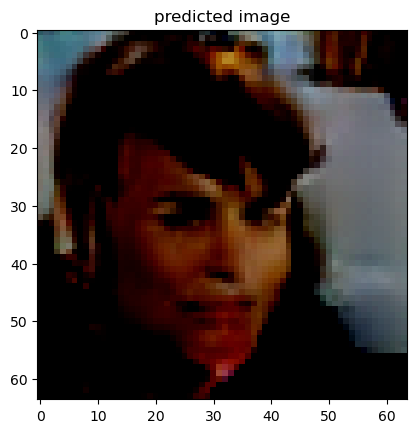

In [11]:
with torch.no_grad():
    G.load_state_dict(torch.load("./models/Generator.pth", map_location=device))
    
    # 특정 공간상의 랜덤한 하나의 점 지정
    feature_vector = torch.randn(1, 100, 1, 1).to(device)
    
    # 이미지 생성
    pred = G(feature_vector).squeeze()
    pred = pred.permute(1, 2, 0).cpu().numpy()
    
    plt.imshow(pred)
    plt.title('predicted image')
    plt.show()

# 학습 마무리

<img src='./figs/13_11.png'>

# 연습문제

<img src='./figs/13_12.png'>